In [1]:
from google.colab import drive
drive.mount('/content/drive')

# %cd /content/drive/MyDrive
# !git clone https://github.com/openai/spinningup.git

#pip 설치
!pip install mpi4py
!pip install box2d

#py파일 참조를 위한 위치 변경
import sys
sys.path.append('/content/drive/MyDrive/Project/hanium/bipedalwalker')

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.3 MB/s eta 0:00:00


In [4]:
from sac import core
from utils.logx import EpochLogger
from utils.mpi_pytorch import setup_pytorch_for_mpi, sync_params, mpi_avg_grads
from utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from utils.run_utils import setup_logger_kwargs

from copy import deepcopy
import gym
import math
import pygame
import random
import time
import os
import argparse
import itertools
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import gym
print(gym.__version__)

0.25.2


In [ ]:
epoch_rewards = []
test_rewards = []
loss_pi_vals = []
loss_q_vals = []
log_pi_vals = []
q1_vals = []
q2_vals = []

In [ ]:
class ReplayBuffer:

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(core.combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(core.combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}



def sac(env_fn, actor_critic=core.MLPActorCritic, ac_kwargs=dict(), seed=0,
        steps_per_epoch=4000, epochs=100, replay_size=int(1e6), gamma=0.99,
        polyak=0.995, lr=1e-3, alpha=0.2, batch_size=256, start_steps=10000,
        update_after=1000, update_every=64, num_test_episodes=10, max_ep_len=1000,
        logger_kwargs=dict(), save_freq=1):

    logger = EpochLogger(**logger_kwargs)
    logger.save_config(locals())

    torch.manual_seed(seed)
    np.random.seed(seed)

    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]

    # Action limit for clamping: critically, assumes all dimensions share the same bound!
    act_limit = env.action_space.high[0]

    # Create actor-critic module and target networks
    ac = actor_critic(env.observation_space, env.action_space, **ac_kwargs)
    ac_targ = deepcopy(ac)

    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for p in ac_targ.parameters():
        p.requires_grad = False

    # List of parameters for both Q-networks (save this for convenience)
    q_params = itertools.chain(ac.q1.parameters(), ac.q2.parameters())

    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    # Count variables (protip: try to get a feel for how different size networks behave!)
    var_counts = tuple(core.count_vars(module) for module in [ac.pi, ac.q1, ac.q2])
    logger.log('\nNumber of parameters: \t pi: %d, \t q1: %d, \t q2: %d\n'%var_counts)

    # Set up function for computing SAC Q-losses
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q1 = ac.q1(o,a)
        q2 = ac.q2(o,a)

        # Bellman backup for Q functions
        with torch.no_grad():
            # Target actions come from *current* policy
            a2, logp_a2 = ac.pi(o2)

            # Target Q-values
            q1_pi_targ = ac_targ.q1(o2, a2)
            q2_pi_targ = ac_targ.q2(o2, a2)
            q_pi_targ = torch.min(q1_pi_targ, q2_pi_targ)
            backup = r + gamma * (1 - d) * (q_pi_targ - alpha * logp_a2)

        # MSE loss against Bellman backup
        loss_q1 = ((q1 - backup)**2).mean()
        loss_q2 = ((q2 - backup)**2).mean()
        loss_q = loss_q1 + loss_q2

        # Useful info for logging
        q_info = dict(Q1Vals=q1.detach().numpy(),
                      Q2Vals=q2.detach().numpy())

        return loss_q, q_info

    # Set up function for computing SAC pi loss
    def compute_loss_pi(data):
        o = data['obs']
        pi, logp_pi = ac.pi(o)
        q1_pi = ac.q1(o, pi)
        q2_pi = ac.q2(o, pi)
        q_pi = torch.min(q1_pi, q2_pi)

        # Entropy-regularized policy loss
        loss_pi = (alpha * logp_pi - q_pi).mean()

        # Useful info for logging
        pi_info = dict(LogPi=logp_pi.detach().numpy())

        return loss_pi, pi_info

    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=lr)
    q_optimizer = Adam(q_params, lr=lr)

    # Set up model saving
    logger.setup_pytorch_saver(ac)

    def update(data):
        # First run one gradient descent step for Q1 and Q2
        q_optimizer.zero_grad()
        loss_q, q_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Record things
        logger.store(LossQ=loss_q.item(), **q_info)

        # Freeze Q-networks so you don't waste computational effort
        # computing gradients for them during the policy learning step.
        for p in q_params:
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi, pi_info = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Unfreeze Q-networks so you can optimize it at next DDPG step.
        for p in q_params:
            p.requires_grad = True

        # Record things
        logger.store(LossPi=loss_pi.item(), **pi_info)

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(ac.parameters(), ac_targ.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(polyak)
                p_targ.data.add_((1 - polyak) * p.data)

    def get_action(o, deterministic=False):
        return ac.act(torch.as_tensor(o, dtype=torch.float32),
                      deterministic)

    def test_agent():
        for j in range(num_test_episodes):
            o, d, ep_ret, ep_len = test_env.reset(), False, 0, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time
                o, r, d, _ = test_env.step(get_action(o, True))
                ep_ret += r
                ep_len += 1
            logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

    # Prepare for interaction with environment
    total_steps = steps_per_epoch * epochs
    start_time = time.time()
    o, ep_ret, ep_len = env.reset(), 0, 0

    # Main loop: collect experience in env and update/log each epoch
    for t in range(total_steps):

        # Until start_steps have elapsed, randomly sample actions
        # from a uniform distribution for better exploration. Afterwards,
        # use the learned policy.
        if t > start_steps:
            a = get_action(o)
        else:
            a = env.action_space.sample()

        # Step the env
        o2, r, d, truncated = env.step(a)
        ep_ret += r
        ep_len += 1

        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        d = False if ep_len==max_ep_len else d

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)

        # Super critical, easy to overlook step: make sure to update
        # most recent observation!
        o = o2

        # End of trajectory handling
        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            o, ep_ret, ep_len = env.reset(), 0, 0

        # Update handling
        if t >= update_after and t % update_every == 0:
            for j in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            # Save model
            if (epoch % save_freq == 0) or (epoch == epochs):
                logger.save_state({'env': env}, None)

            # Test the performance of the deterministic version of the agent.
            test_agent()

            ep_ret_mean = logger.get_stats('EpRet')[0]
            test_ret_mean = logger.get_stats('TestEpRet')[0]
            loss_pi = logger.get_stats('LossPi')[0]
            loss_q = logger.get_stats('LossQ')[0]
            log_pi = logger.get_stats('LogPi')[0]
            q1 = logger.get_stats('Q1Vals')[0]
            q2 = logger.get_stats('Q2Vals')[0]

            # 저장
            epoch_rewards.append(ep_ret_mean)
            test_rewards.append(test_ret_mean)
            loss_pi_vals.append(loss_pi)
            loss_q_vals.append(loss_q)
            log_pi_vals.append(log_pi)
            q1_vals.append(q1)
            q2_vals.append(q2)

            # Log info about epoch
            logger.log_tabular('Epoch', epoch)
            logger.log_tabular('EpRet', with_min_and_max=True)
            logger.log_tabular('TestEpRet', with_min_and_max=True)
            logger.log_tabular('EpLen', average_only=True)
            logger.log_tabular('TestEpLen', average_only=True)
            logger.log_tabular('TotalEnvInteracts', t)
            logger.log_tabular('Q1Vals', with_min_and_max=True)
            logger.log_tabular('Q2Vals', with_min_and_max=True)
            logger.log_tabular('LogPi', with_min_and_max=True)
            logger.log_tabular('LossPi', average_only=True)
            logger.log_tabular('LossQ', average_only=True)
            logger.log_tabular('Time', time.time()-start_time)
            logger.dump_tabular()

In [ ]:
if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--env', type=str, default='BipedalWalker-v3')
    parser.add_argument('--hid', type=int, default=256)
    parser.add_argument('--l', type=int, default=2)
    parser.add_argument('--gamma', type=float, default=0.98)
    parser.add_argument('--seed', '-s', type=int, default=0)
    parser.add_argument('--epochs', type=int, default=50)
    parser.add_argument('--exp_name', type=str, default='sac')
    args, _ = parser.parse_known_args()

    from utils.run_utils import setup_logger_kwargs
    logger_kwargs = setup_logger_kwargs(args.exp_name, args.seed)

    torch.set_num_threads(torch.get_num_threads())

    sac(lambda : gym.make(args.env), actor_critic=core.MLPActorCritic,
        ac_kwargs=dict(hidden_sizes=[args.hid]*args.l),
        gamma=args.gamma, seed=args.seed, epochs=args.epochs,
        logger_kwargs=logger_kwargs)

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/sac/sac_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256,
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	256,
    "env_fn":	"<function <lambda> at 0x79bdd0929bc0>",
    "epochs":	50,
    "exp_name":	"sac",
    "gamma":	0.98,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x79bdd090b150>":	{
            "epoch_dict":	{},
            "exp_name":	"sac",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/sac/sac_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/sac/sac_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	"w"
                }
            }
        }
    

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -99.8 |
|          StdEpRet |            18.9 |
|          MaxEpRet |           -45.8 |
|          MinEpRet |            -119 |
|  AverageTestEpRet |           -27.6 |
|      StdTestEpRet |            2.56 |
|      MaxTestEpRet |           -21.7 |
|      MinTestEpRet |           -31.3 |
|             EpLen |             175 |
|         TestEpLen |           1e+03 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |            1.14 |
|         StdQ1Vals |            7.82 |
|         MaxQ1Vals |            7.81 |
|         MinQ1Vals |            -137 |
|     AverageQ2Vals |            1.14 |
|         StdQ2Vals |            7.83 |
|         MaxQ2Vals |            8.49 |
|         MinQ2Vals |            -132 |
|      AverageLogPi |           -1.64 |
|          StdLogPi |            1.82 |
|          MaxLogPi |            18.1 |
|          MinLogPi |           -10.5 |


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-7-4104729939.py", line 18, in <cell line: 0>
    sac(lambda : gym.make(args.env), actor_critic=core.MLPActorCritic,
  File "/tmp/ipython-input-4-3579735820.py", line 212, in sac
    update(data=batch)
  File "/tmp/ipython-input-4-3579735820.py", line 123, in update
    loss_q, q_info = compute_loss_q(data)
                     ^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-4-3579735820.py", line 78, in compute_loss_q
    a2, logp_a2 = ac.pi(o2)
                  ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl


TypeError: object of type 'NoneType' has no len()

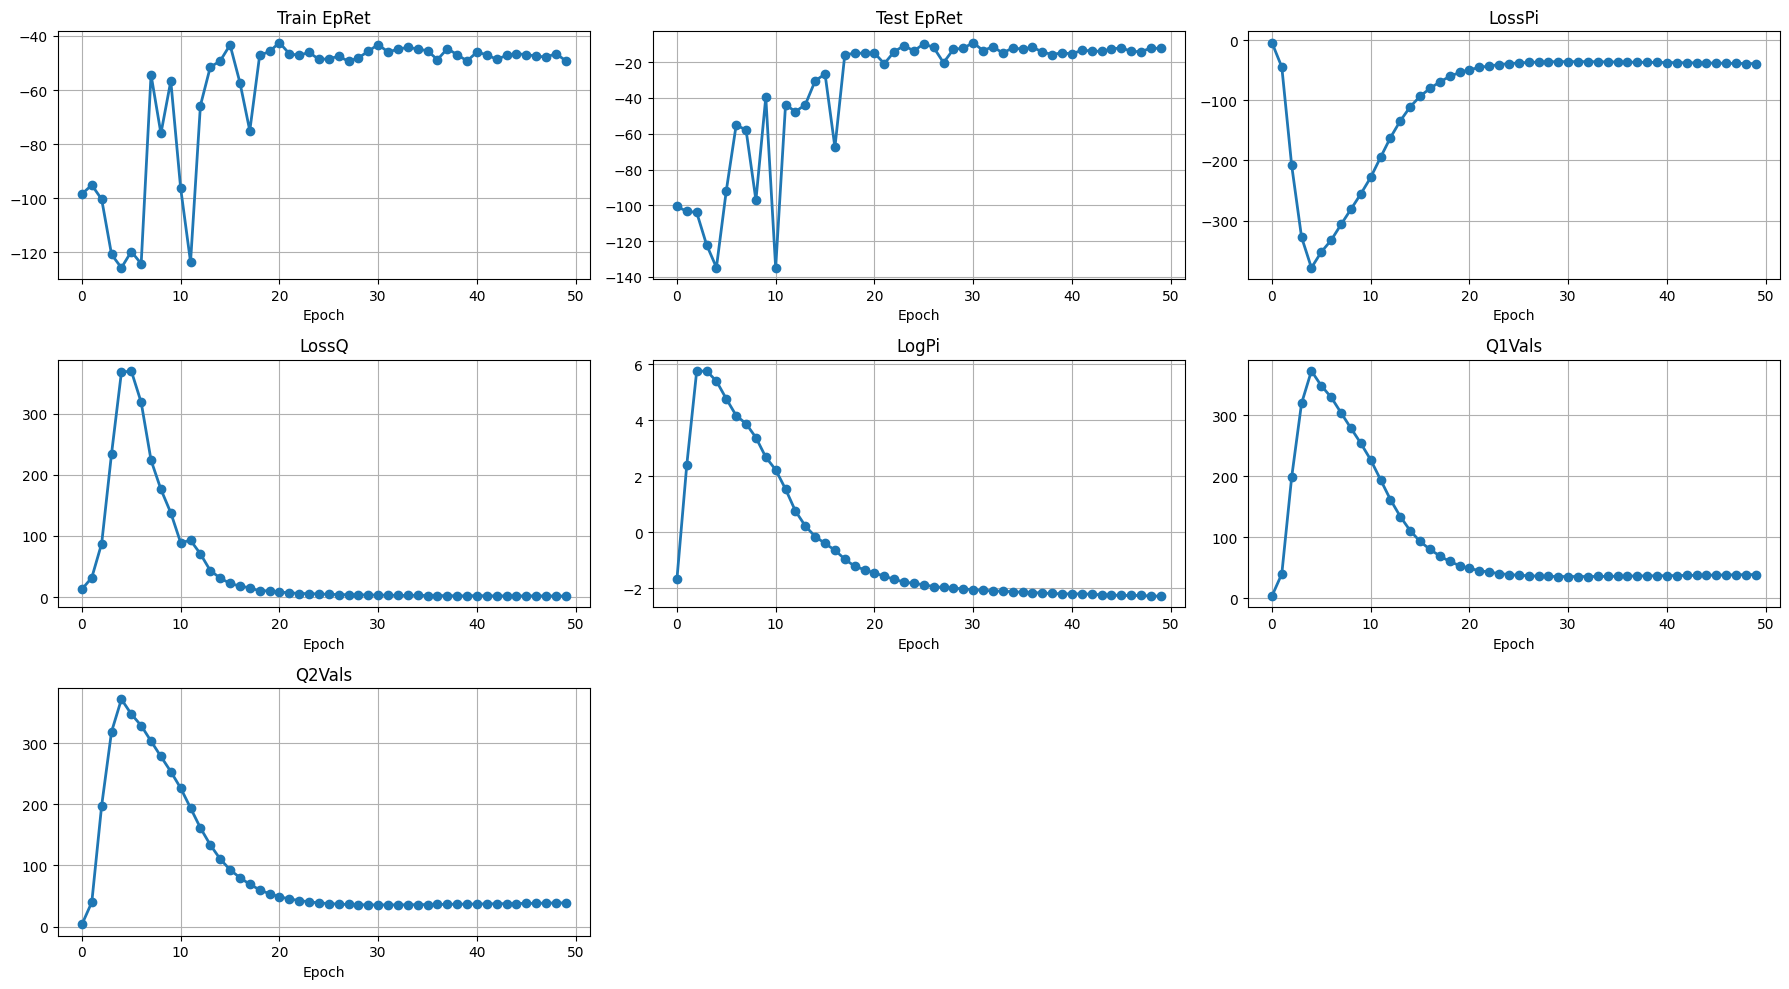

In [ ]:
epochs = list(range(len(epoch_rewards)))

metrics = {
    'Train EpRet': epoch_rewards,
    'Test EpRet': test_rewards,
    'LossPi': loss_pi_vals,
    'LossQ': loss_q_vals,
    'LogPi': log_pi_vals,
    'Q1Vals': q1_vals,
    'Q2Vals': q2_vals
}

plt.figure(figsize=(18, 10))
for i, (title, values) in enumerate(metrics.items(), 1):
    plt.subplot(3, 3, i)
    plt.plot(epochs, values, marker='o', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.8 MB/s eta 0:00:00


In [ ]:
import importlib
import sac.sac
importlib.reload(sac.sac)

<module 'sac.sac' from '/content/drive/MyDrive/Project/hanium/bipedalwalker/sac/sac.py'>

In [ ]:
import optuna
from sac.sac import sac   # 학습 함수 직접 불러오기
import gym
from utils.run_utils import setup_logger_kwargs
from sac import core

def objective(trial):
    # Optuna 튜닝 대상
    gamma = trial.suggest_categorical("gamma", [0.95, 0.98, 0.99, 0.995])
    tau = trial.suggest_categorical("tau", [0.005, 0.01, 0.02])
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    alpha = trial.suggest_categorical("alpha", [0.1, 0.2])
    update_every = trial.suggest_categorical("update_every", [10, 50, 100])
    start_steps = trial.suggest_categorical("start_steps", [1000, 5000, 10000])
    hidden_sizes = trial.suggest_categorical("hidden_sizes", [[256, 256], [400, 300]])

    # 로거 설정 등
    from utils.logx import EpochLogger
    ac_kwargs = dict(hidden_sizes=hidden_sizes)
    logger_kwargs = setup_logger_kwargs(f"trial_{trial.number}", seed=0)

    # 환경 및 actor 생성
    env_fn = lambda: gym.make("BipedalWalker-v3")

    # ppo 실행
    result = sac(
        env_fn,
        actor_critic=core.MLPActorCritic,
        ac_kwargs=ac_kwargs,
        gamma=gamma,
        polyak=tau,
        lr=lr,
        alpha=alpha,
        batch_size=batch_size,
        start_steps=start_steps,
        update_every=update_every,
        logger_kwargs=logger_kwargs,
        seed=0,
        epochs=30,
        steps_per_epoch=4000,
    )


    # ppo 내부에서 마지막 reward 값을 반환하도록 해야 함
    return result  # 예: 평균 reward 등

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)

[I 2025-07-12 07:14:15,571] A new study created in memory with name: no-name-f3b565f4-4a4a-46f8-9584-a831bfb8bd9a
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_co

Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_0/trial_0_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            400,
            300
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	256,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc3060>",
    "epochs":	30,
    "exp_name":	"trial_0",
    "gamma":	0.99,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b3252a52bd0>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_0",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_0/trial_0_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_0/trial_0_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

[W 2025-07-12 07:52:21,369] Trial 0 failed with parameters: {'gamma': 0.99, 'tau': 0.02, 'lr': 0.0008929773790088332, 'batch_size': 256, 'alpha': 0.2, 'update_every': 50, 'start_steps': 1000, 'hidden_sizes': [400, 300]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 07:52:21,370] Trial 0 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_1/trial_1_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256,
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	128,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252a9ed40>",
    "epochs":	30,
    "exp_name":	"trial_1",
    "gamma":	0.95,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b3252afbad0>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_1",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_1/trial_1_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_1/trial_1_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 74248, 	 q1: 73473, 	 q2: 73473

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -94.1 |
|          StdEpRet |            30.1 |
|          MaxEpRet |           -45.9 |
|          MinEpRet |            -131 |
|  AverageTestEpRet |            -101 |
|      StdTestEpRet |            41.2 |
|      MaxTestEpRet |           -34.2 |
|      MinTestEpRet |            -134 |
|             EpLen |             358 |
|         TestEpLen |             430 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |             7.4 |
|         StdQ1Vals |            5.03 |
|         MaxQ1Vals |            32.7 |
|         MinQ1Vals |            -118 |
|     AverageQ2Vals |             7.4 |
|         StdQ2Vals |            5.01 |
|         MaxQ2Vals |            32.6 |
|         MinQ2Vals |            -122 |
|      AverageLogPi |           -2.15 |
|          StdLogPi |             1.3 |
|          MaxLogP

[W 2025-07-12 08:23:02,957] Trial 1 failed with parameters: {'gamma': 0.95, 'tau': 0.005, 'lr': 0.0009915936743939181, 'batch_size': 128, 'alpha': 0.2, 'update_every': 10, 'start_steps': 5000, 'hidden_sizes': [256, 256]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 08:23:02,958] Trial 1 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_2/trial_2_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256,
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.1,
    "batch_size":	64,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc34c0>",
    "epochs":	30,
    "exp_name":	"trial_2",
    "gamma":	0.99,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b321c307410>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_2",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_2/trial_2_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_2/trial_2_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 74248, 	 q1: 73473, 	 q2: 73473

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |             -94 |
|          StdEpRet |            26.8 |
|          MaxEpRet |           -49.4 |
|          MinEpRet |            -123 |
|  AverageTestEpRet |            -116 |
|      StdTestEpRet |           0.797 |
|      MaxTestEpRet |            -113 |
|      MinTestEpRet |            -116 |
|             EpLen |             330 |
|         TestEpLen |             127 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |        2.64e+05 |
|         StdQ1Vals |        4.45e+05 |
|         MaxQ1Vals |        2.63e+06 |
|         MinQ1Vals |           -22.4 |
|     AverageQ2Vals |        2.64e+05 |
|         StdQ2Vals |        4.45e+05 |
|         MaxQ2Vals |        2.63e+06 |
|         MinQ2Vals |           -21.4 |
|      AverageLogPi |            27.2 |
|          StdLogPi |            22.6 |
|          MaxLogP

[W 2025-07-12 08:45:31,020] Trial 2 failed with parameters: {'gamma': 0.99, 'tau': 0.01, 'lr': 0.000499925345243295, 'batch_size': 64, 'alpha': 0.1, 'update_every': 50, 'start_steps': 5000, 'hidden_sizes': [256, 256]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 08:45:31,020] Trial 2 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_3/trial_3_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256,
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.1,
    "batch_size":	128,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252a9d9e0>",
    "epochs":	30,
    "exp_name":	"trial_3",
    "gamma":	0.98,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b32500a0e10>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_3",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_3/trial_3_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_3/trial_3_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 74248, 	 q1: 73473, 	 q2: 73473

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |            -101 |
|          StdEpRet |            19.3 |
|          MaxEpRet |           -51.3 |
|          MinEpRet |            -123 |
|  AverageTestEpRet |            -105 |
|      StdTestEpRet |            0.44 |
|      MaxTestEpRet |            -105 |
|      MinTestEpRet |            -106 |
|             EpLen |             190 |
|         TestEpLen |             109 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |            25.4 |
|         StdQ1Vals |            19.5 |
|         MaxQ1Vals |            92.2 |
|         MinQ1Vals |            -144 |
|     AverageQ2Vals |            25.4 |
|         StdQ2Vals |            19.5 |
|         MaxQ2Vals |              96 |
|         MinQ2Vals |            -145 |
|      AverageLogPi |            1.14 |
|          StdLogPi |            3.07 |
|          MaxLogP

[W 2025-07-12 09:14:17,922] Trial 3 failed with parameters: {'gamma': 0.98, 'tau': 0.01, 'lr': 0.00040582045925615284, 'batch_size': 128, 'alpha': 0.1, 'update_every': 10, 'start_steps': 5000, 'hidden_sizes': [256, 256]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 09:14:17,922] Trial 3 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_4/trial_4_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256,
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.1,
    "batch_size":	128,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc36a0>",
    "epochs":	30,
    "exp_name":	"trial_4",
    "gamma":	0.98,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b3252b17850>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_4",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_4/trial_4_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_4/trial_4_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 74248, 	 q1: 73473, 	 q2: 73473

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -68.1 |
|          StdEpRet |            30.2 |
|          MaxEpRet |           -47.2 |
|          MinEpRet |            -120 |
|  AverageTestEpRet |           -88.6 |
|      StdTestEpRet |            36.7 |
|      MaxTestEpRet |           -29.6 |
|      MinTestEpRet |            -127 |
|             EpLen |             776 |
|         TestEpLen |             430 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |            11.5 |
|         StdQ1Vals |            2.91 |
|         MaxQ1Vals |            26.1 |
|         MinQ1Vals |           -61.7 |
|     AverageQ2Vals |            11.5 |
|         StdQ2Vals |            2.92 |
|         MaxQ2Vals |            26.2 |
|         MinQ2Vals |           -61.7 |
|      AverageLogPi |           -1.88 |
|          StdLogPi |            1.35 |
|          MaxLogP

[W 2025-07-12 09:43:01,268] Trial 4 failed with parameters: {'gamma': 0.98, 'tau': 0.005, 'lr': 0.00018561397739099797, 'batch_size': 128, 'alpha': 0.1, 'update_every': 100, 'start_steps': 5000, 'hidden_sizes': [256, 256]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 09:43:01,269] Trial 4 failed with value None.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_5/trial_5_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            400,
            300
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	64,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc2840>",
    "epochs":	30,
    "exp_name":	"trial_5",
    "gamma":	0.995,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b321c305f90>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_5",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_5/trial_5_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_5/trial_5_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 132708, 	 q1: 132201, 	 q2: 132201

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -73.3 |
|          StdEpRet |            23.4 |
|          MaxEpRet |           -51.8 |
|          MinEpRet |            -102 |
|  AverageTestEpRet |            -111 |
|      StdTestEpRet |            1.34 |
|      MaxTestEpRet |            -108 |
|      MinTestEpRet |            -112 |
|             EpLen |             635 |
|         TestEpLen |             824 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |        2.98e+04 |
|         StdQ1Vals |         3.6e+04 |
|         MaxQ1Vals |        1.38e+05 |
|         MinQ1Vals |         -0.0507 |
|     AverageQ2Vals |        2.98e+04 |
|         StdQ2Vals |        3.59e+04 |
|         MaxQ2Vals |        1.38e+05 |
|         MinQ2Vals |          -0.081 |
|      AverageLogPi |            12.9 |
|          StdLogPi |            8.65 |
|          MaxL

[W 2025-07-12 10:08:25,727] Trial 5 failed with parameters: {'gamma': 0.995, 'tau': 0.01, 'lr': 0.00010460806342414992, 'batch_size': 64, 'alpha': 0.2, 'update_every': 10, 'start_steps': 5000, 'hidden_sizes': [400, 300]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 10:08:25,728] Trial 5 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_6/trial_6_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            400,
            300
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.1,
    "batch_size":	64,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc36a0>",
    "epochs":	30,
    "exp_name":	"trial_6",
    "gamma":	0.95,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b3250080ad0>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_6",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_6/trial_6_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_6/trial_6_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":	

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 132708, 	 q1: 132201, 	 q2: 132201

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -93.6 |
|          StdEpRet |            22.2 |
|          MaxEpRet |           -45.8 |
|          MinEpRet |            -114 |
|  AverageTestEpRet |           -47.5 |
|      StdTestEpRet |            18.8 |
|      MaxTestEpRet |           -28.2 |
|      MinTestEpRet |             -67 |
|             EpLen |             249 |
|         TestEpLen |           1e+03 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |            5.06 |
|         StdQ1Vals |            8.55 |
|         MaxQ1Vals |            80.3 |
|         MinQ1Vals |            -123 |
|     AverageQ2Vals |            5.06 |
|         StdQ2Vals |            8.66 |
|         MaxQ2Vals |            79.8 |
|         MinQ2Vals |            -130 |
|      AverageLogPi |          -0.598 |
|          StdLogPi |            2.48 |
|          MaxL

[W 2025-07-12 10:36:59,478] Trial 6 failed with parameters: {'gamma': 0.95, 'tau': 0.005, 'lr': 0.0006554717141609738, 'batch_size': 64, 'alpha': 0.1, 'update_every': 50, 'start_steps': 10000, 'hidden_sizes': [400, 300]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 10:36:59,479] Trial 6 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_7/trial_7_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            400,
            300
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	256,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc2840>",
    "epochs":	30,
    "exp_name":	"trial_7",
    "gamma":	0.95,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b321c2eddd0>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_7",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_7/trial_7_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_7/trial_7_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 132708, 	 q1: 132201, 	 q2: 132201

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -73.8 |
|          StdEpRet |            29.2 |
|          MaxEpRet |           -46.4 |
|          MinEpRet |            -114 |
|  AverageTestEpRet |           -76.8 |
|      StdTestEpRet |            5.46 |
|      MaxTestEpRet |           -72.6 |
|      MinTestEpRet |           -86.3 |
|             EpLen |             624 |
|         TestEpLen |           1e+03 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |            9.15 |
|         StdQ1Vals |            4.52 |
|         MaxQ1Vals |            75.3 |
|         MinQ1Vals |            -103 |
|     AverageQ2Vals |            9.14 |
|         StdQ2Vals |            4.49 |
|         MaxQ2Vals |            76.2 |
|         MinQ2Vals |           -94.4 |
|      AverageLogPi |           -1.91 |
|          StdLogPi |            1.73 |
|          MaxL

[W 2025-07-12 11:12:23,168] Trial 7 failed with parameters: {'gamma': 0.95, 'tau': 0.005, 'lr': 0.0002628483079927362, 'batch_size': 256, 'alpha': 0.2, 'update_every': 50, 'start_steps': 5000, 'hidden_sizes': [400, 300]} because of the following error: The value None could not be cast to float..
[W 2025-07-12 11:12:23,168] Trial 7 failed with value None.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [400, 300] which is of type list.
  warnings.warn(message)


Logging data to /content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_8/trial_8_s0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            256,
            256
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	256,
    "env_fn":	"<function objective.<locals>.<lambda> at 0x7b3252bc36a0>",
    "epochs":	30,
    "exp_name":	"trial_8",
    "gamma":	0.99,
    "logger":	{
        "<utils.logx.EpochLogger object at 0x7b325014f390>":	{
            "epoch_dict":	{},
            "exp_name":	"trial_8",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_8/trial_8_s0",
            "output_file":	{
                "<_io.TextIOWrapper name='/content/drive/MyDrive/Project/hanium/bipedalwalker/data/trial_8/trial_8_s0/progress.txt' mode='w' encoding='utf-8'>":	{
                    "mode":

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Number of parameters: 	 pi: 74248, 	 q1: 73473, 	 q2: 73473

---------------------------------------
|             Epoch |               1 |
|      AverageEpRet |           -98.9 |
|          StdEpRet |            16.8 |
|          MaxEpRet |           -59.2 |
|          MinEpRet |            -119 |
|  AverageTestEpRet |            -111 |
|      StdTestEpRet |           0.611 |
|      MaxTestEpRet |            -110 |
|      MinTestEpRet |            -111 |
|             EpLen |             263 |
|         TestEpLen |            49.5 |
| TotalEnvInteracts |           4e+03 |
|     AverageQ1Vals |             125 |
|         StdQ1Vals |             277 |
|         MaxQ1Vals |        1.99e+03 |
|         MinQ1Vals |            -206 |
|     AverageQ2Vals |             125 |
|         StdQ2Vals |             277 |
|         MaxQ2Vals |        1.99e+03 |
|         MinQ2Vals |            -196 |
|      AverageLogPi |          -0.498 |
|          StdLogPi |            3.14 |
|          MaxLogP